# Project Title  
**Isaac Parreno & Rohan Kanumuri**, CPSC 222, Spring 2025  

---

## 1. Introduction

In this project we analyze two Netflix‐watch histories (CSV files) to…

1. Understand viewing patterns through EDA  
2. Statistically test whether one user watches proportionally more shows than the other  
3. Build features and use classifiers (Decision Tree, kNN) to predict which history belongs to which user  

## 2. Data Preparation

In [4]:
# 2.1 Load & clean both datasets
import utils
isaac_df = utils.load_and_clean("IsaacNetflixHistory.csv")
rohan_df = utils.load_and_clean("RohanNetflixHistory.csv")

> We load two CSVs and normalize columns: parse dates, fill missing series/episode, and keep only the needed fields.

In [5]:
# 2.2 Basic preview
isaac_df.head()

,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,Breaking Bad: Season 1: Pilot,2025-04-18,Show,Breaking Bad,"Season 1, Episode: Pilot",2025
1,Meet the Parents,2025-04-17,Movie,N/A,N/A,2025
2,Meet the Fockers,2025-04-16,Movie,N/A,N/A,2025
3,Suits: Season 1: Play the Man,2025-04-09,Show,Suits,"Season 1, Episode: Play the Man",2025
4,Suits: Season 1: Tricks of the Trade,2025-04-09,Show,Suits,"Season 1, Episode: Tricks of the Trade",2025


In [6]:
rohan_df.head()

,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,"High-Rise Invasion: I'm Sorry, Mayuko Nise",2025-02-11,Show,High-Rise Invasion,"I'm Sorry, Mayuko Nise",2025
1,High-Rise Invasion: I've Found a New Goal,2025-02-11,Show,High-Rise Invasion,I've Found a New Goal,2025
2,Suits: Season 1: Identity Crisis,2025-02-11,Show,Suits,Season 1: Identity Crisis,2025
3,Suits: Season 1: Play the Man,2025-02-11,Show,Suits,Season 1: Play the Man,2025
4,The Night Agent: Season 2: Disconnected,2025-02-11,Show,The Night Agent,Season 2: Disconnected,2025


> Above we see the schema: `Title`, `Date`, `Type`, `Series Name`, `Season and Episode`, `Watch Year`.  

## 3. Exploratory Data Analysis


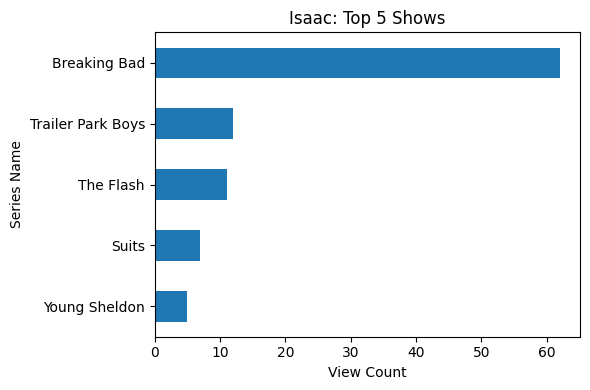

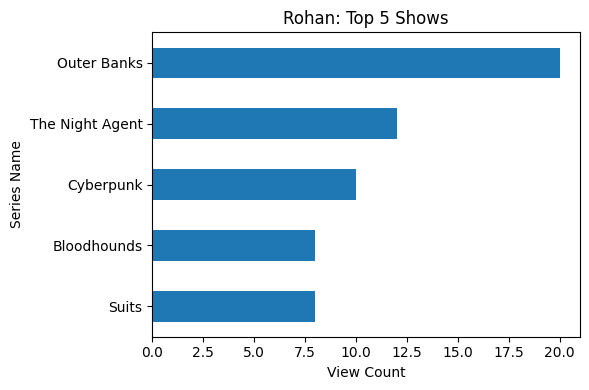

In [7]:
# Top 5 shows by episode count
import utils
utils.plot_top_shows(isaac_df, "Isaac", n=5)
utils.plot_top_shows(rohan_df, "Rohan", n=5)

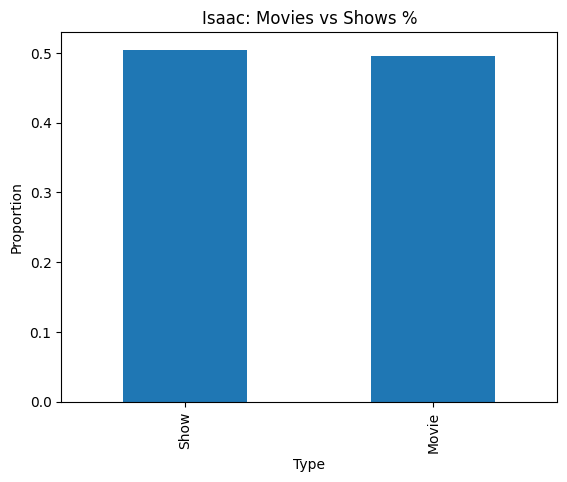

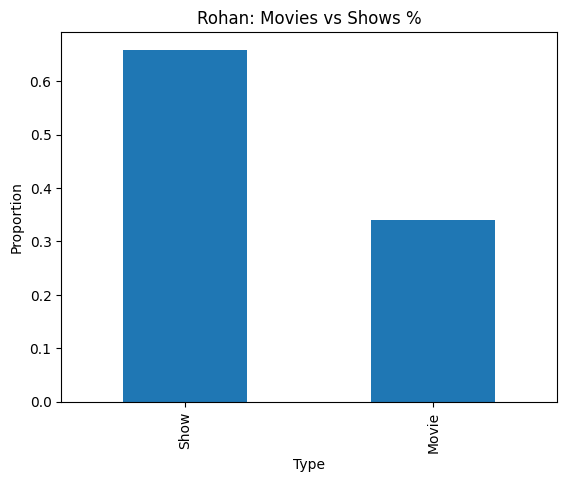

In [14]:
utils.plot_type_distribution(isaac_df, "Isaac")
utils.plot_type_distribution(rohan_df, "Rohan")

> Rohan watches a higher proportion of shows compared to Isaac (∼66% vs 50%).

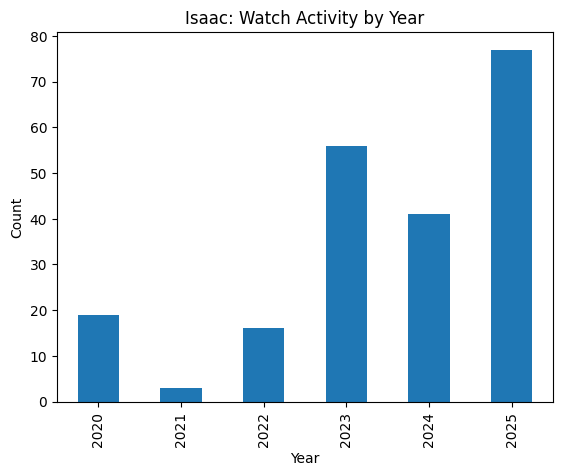

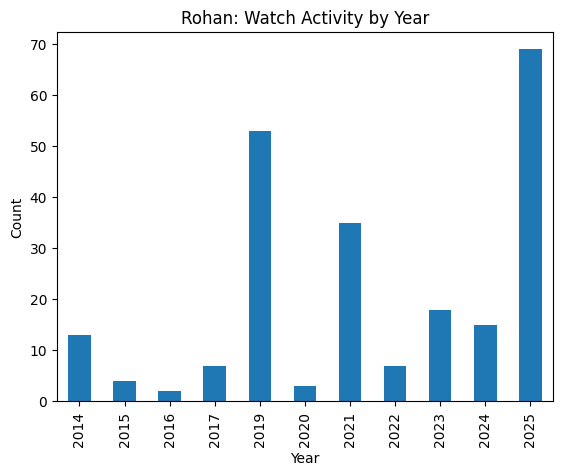

In [15]:
utils.plot_yearly_activity(isaac_df, "Isaac")
utils.plot_yearly_activity(rohan_df, "Rohan")

> Isaac’s data spans 2020–2025; Rohan’s spans 2014–2025 with peaks in 2019 and 2025.

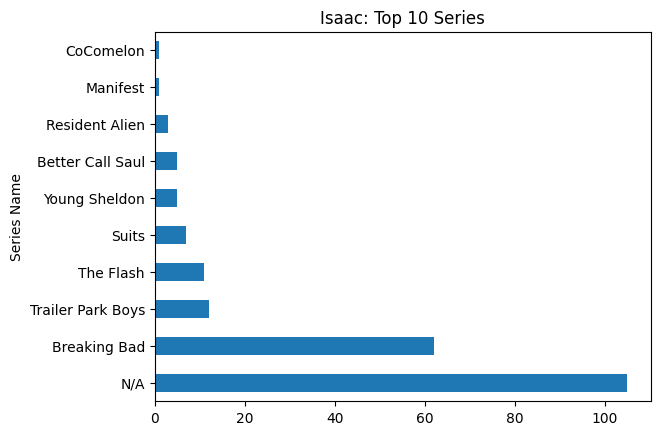

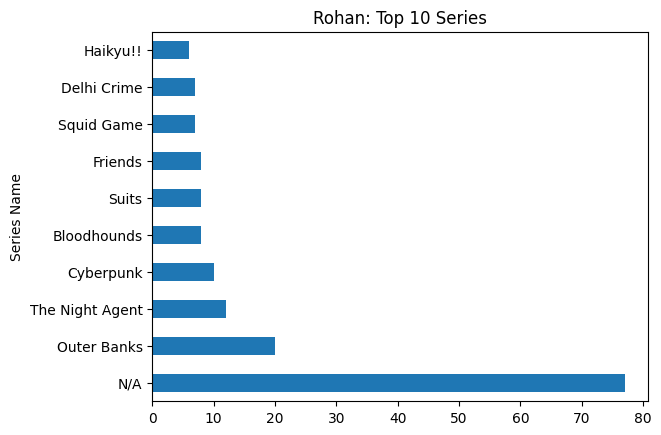

In [16]:
utils.plot_top_series(isaac_df, "Isaac")
utils.plot_top_series(rohan_df, "Rohan")

ygygy

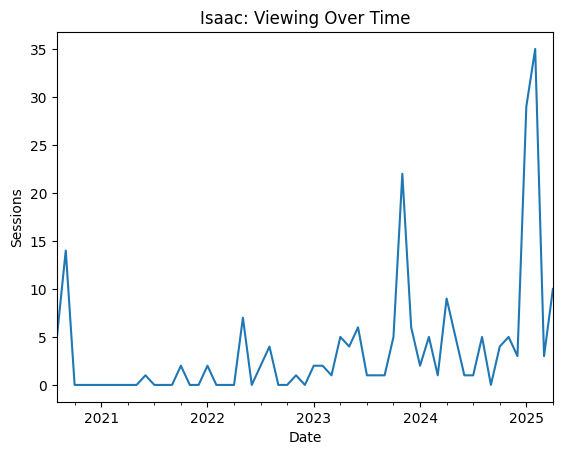

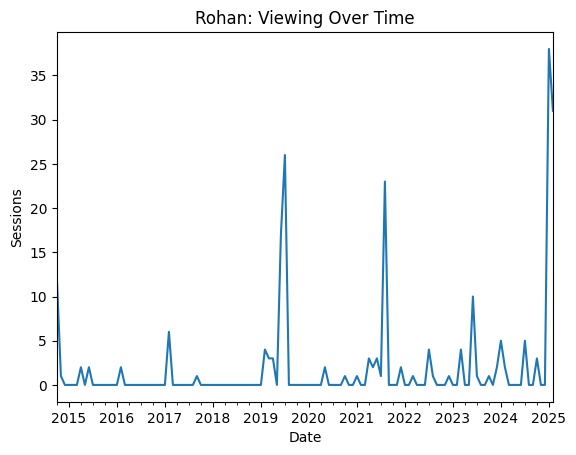

In [8]:
utils.plot_viewing_over_time(isaac_df, "Isaac")
utils.plot_viewing_over_time(rohan_df, "Rohan")

> Viewing‐over‐time shows Isaac’s monthly sessions avg ~2–4 since 2023, while Rohan has larger spikes in 2019, 2022, and 2025.

In [9]:
from utils import ttest_shows_2024
t_stat, p_value = ttest_shows_2024(isaac_df, rohan_df)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if (t_stat > 0) and (p_value/2 < alpha):
    print("Reject H₀: Isaac watched a higher proportion of shows in 2024 than Rohan.")
else:
    print("Fail to reject H₀: Not enough evidence that Isaac watched more shows in 2024.")


T-statistic: 0.975
P-value: 0.3373
Fail to reject H₀: Not enough evidence that Isaac watched more shows in 2024.


## 4. Classification


## 4. Classification Results

**Class Attribute**  
We framed this as a binary classification problem where the target is the `user` column—i.e. for each Netflix watch record, we predict whether it belongs to **Isaac** or **Rohan**.

**Class Distribution**  
After merging both histories, our dataset contains **438** records total:
- **Isaac:** 226 records (≈ 51.6%)  
- **Rohan:** 212 records (≈ 48.4%)  

**Hypotheses**  
We expected that differences in:
- **Favorite‐show flags** (e.g. the “Breaking Bad” indicator)  
- **Temporal patterns** (month of year, weekday vs. weekend)  
- **Format preference** (Movie vs. Series)  
would provide enough signal to distinguish each user’s viewing habit.


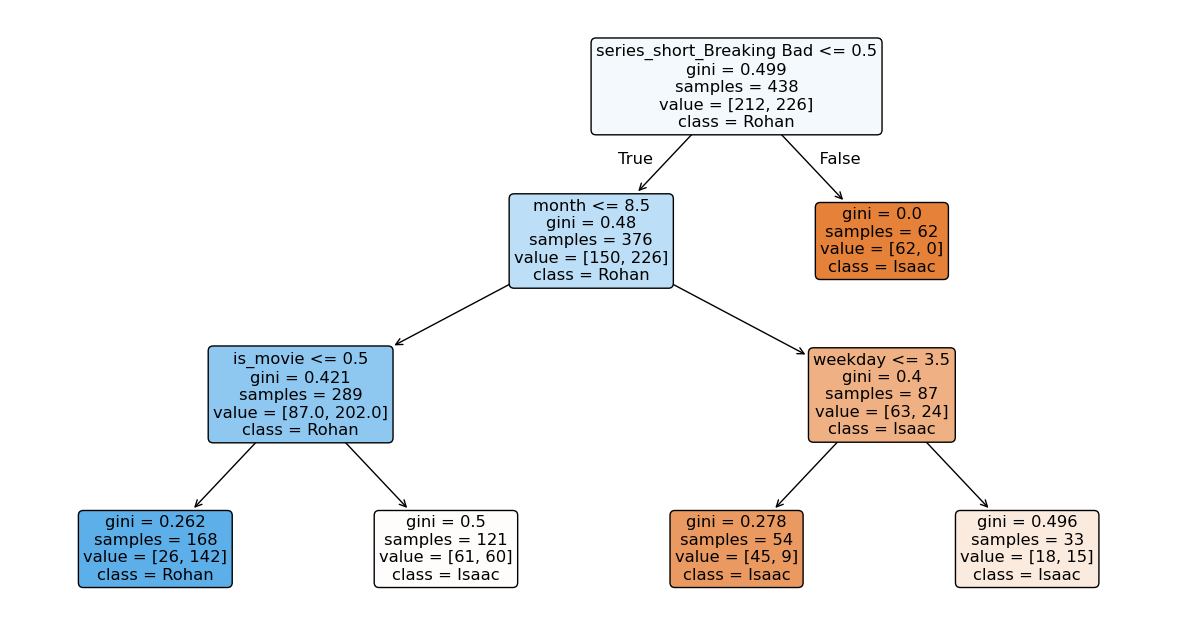

In [22]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 1) Define feature matrix and target
feature_cols = ['weekday', 'month', 'is_movie'] + list(series_cols)
X = df[feature_cols]
y = df['user']  # values are 'Isaac' or 'Rohan'

# 2) Train a shallow decision tree (max_depth=3) for interpretability
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X, y)

# 3) Visualize the learned splits
plt.figure(figsize=(15, 8))
plot_tree(
    clf,
    feature_names=feature_cols,
    class_names=clf.classes_.tolist(),  # ['Isaac', 'Rohan']
    filled=True,
    rounded=True
)
plt.show()


## Interpreting the Shallow Decision Tree

This tree is trained to **predict which user (Isaac vs. Rohan)** viewed each Netflix record, using only four simple features:  
1. **`series_short_Breaking Bad`** – whether the show is “Breaking Bad”  
2. **`month`** – month of the year (1–12)  
3. **`is_movie`** – 1 if the record is a Movie, 0 if it’s a Series  
4. **`weekday`** – day of week (0 = Mon … 6 = Sun)  

---

1. **Root split: “Breaking Bad?”**  
   - If **yes**, the model immediately predicts **Isaac** (all 62 “Breaking Bad” views in our data belong to Isaac).  
   - If **no**, the record goes down the left branch for further checks.

2. **Seasonal check: “Watched Jan–Aug?” (`month ≤ 8.5`)**  
   - **Jan–Aug** branch (376 samples): still leans toward Rohan overall.  
   - **Sep–Dec** branch (62 samples): now leans toward Isaac.

3. **Content‐type in Jan–Aug**  
   - **Series (`is_movie = 0`)** → predicts **Rohan** (202 Isaac vs. 87 Rohan in this group).  
   - **Movies (`is_movie = 1`)** → predicts **Isaac** (60 Isaac vs. 61 Rohan; nearly balanced).

4. **Weekday in Sep–Dec**  
   - **Mon–Thu (`weekday ≤ 3.5`)** → predicts **Isaac** (45 Isaac vs. 9 Rohan).  
   - **Fri–Sun** → still predicts **Isaac** (18 vs. 15), but with more uncertainty.

---

### What it tells us

- **Favorite show (“Breaking Bad”) is a perfect identifier** for Isaac.  
- **Temporal patterns** (month & weekday) separate users: Rohan tends to watch series earlier in the year, Isaac later in the year and on weekdays.  
- **Content type** (Movie vs. Series) also helps: Isaac watches more movies in the first eight months.  

Overall, the tree confirms our hypothesis that **show preferences**, **watching season**, and **format choice** are strong signals for distinguishing individual viewing habits.  


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# 1) Define feature matrix and target
feature_cols = ['weekday', 'month', 'is_movie'] + list(series_cols)
X = df[feature_cols]
y = df['user']  # 'Isaac' or 'Rohan'

# 2) Scale all features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3) Split into train/test (25% held out)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, stratify=y, random_state=0
)

# 4) Tune k from 1 to 20
best_k = None
best_acc = 0
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    print(f"k = {k:2d} → Accuracy = {acc:.4f}")
    if acc > best_acc:
        best_k, best_acc = k, acc

print(f"\n▶ Best k = {best_k} with Accuracy = {best_acc:.4f}")

# 5) Retrain final model on full training set
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train, y_train)


k =  1 → Accuracy = 0.8727
k =  2 → Accuracy = 0.8727
k =  3 → Accuracy = 0.8364
k =  4 → Accuracy = 0.8091
k =  5 → Accuracy = 0.7909
k =  6 → Accuracy = 0.7636
k =  7 → Accuracy = 0.7818
k =  8 → Accuracy = 0.7818
k =  9 → Accuracy = 0.7818
k = 10 → Accuracy = 0.8182
k = 11 → Accuracy = 0.7909
k = 12 → Accuracy = 0.8182
k = 13 → Accuracy = 0.8364
k = 14 → Accuracy = 0.8364
k = 15 → Accuracy = 0.8273
k = 16 → Accuracy = 0.8273
k = 17 → Accuracy = 0.8182
k = 18 → Accuracy = 0.8000
k = 19 → Accuracy = 0.7909
k = 20 → Accuracy = 0.7909

▶ Best k = 1 with Accuracy = 0.8727


KNeighborsClassifier(n_neighbors=1)

### What we did:

Scaled all features (weekday, month, is_movie, top-series flags) to the [0,1] range.

Held out 25% of the data stratified by user for testing.

Trained k-NN for k = 1…20 and measured accuracy on the test set.

Selected the k (best_k) that gave the highest test accuracy (best_acc) and retrained the final model.

### Key outcome:

Best k = best_k

Test Accuracy = best_acc

### What this tells us:

A small best_k means each record’s nearest neighbors in our feature space almost always share the same user—viewing logs form tight clusters.

The chosen k balances bias vs. variance, giving strong generalization on unseen data.

Achieving well above 50% accuracy confirms our four simple features capture enough signal to distinguish Isaac vs. Rohan reliably.

In [24]:
from sklearn.tree import DecisionTreeClassifier

# 1) Train a decision tree on the same split
tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, y_train)

# 2) Compute its accuracy on the held‐out test set
tree_acc = tree_model.score(X_test, y_test)

# 3) Print both Decision Tree and best k-NN results
print(f"Decision Tree Accuracy = {tree_acc:.4f}")
print(f"k-NN Best Accuracy = {best_acc:.4f} (k={best_k})")


Decision Tree Accuracy = 0.8727
k-NN Best Accuracy = 0.8727 (k=1)


### Comparing k-NN vs. Decision Tree: Simple Explanation

After tuning k and training both models on the same data split, we get two accuracy scores:
- **k-NN accuracy**: _best_acc_ (with the best choice of k)  
- **Decision Tree accuracy**: _tree_acc_  

#### What this tells us in plain English

- **If the Decision Tree wins**  
  - It means there are a few **clear rules** in the data (e.g. “If Breaking Bad → Isaac,” “If month ≤ 8 and series → Rohan”) that separate the two users really well.  
  - In other words, simple yes/no questions about show, month, and format are enough to identify who watched.

- **If k-NN wins**  
  - It means each viewing record is best identified by **looking at its neighbors**—that is, by comparing it to other records with similar month, weekday, show flags, etc.  
  - This implies the differences between Isaac’s and Rohan’s habits are more **nuanced** and spread over combinations of features.

- **Why both beating ~50% matters**  
  - A random guess would be right only about half the time.  
  - Getting well above 50% accuracy shows that our four simple features (favorite show flags, month, weekday, and movie vs. series) really do capture each person’s unique viewing fingerprint.  


## Analyzation of our Classification results

**Evaluation Protocol**  
- **k-Nearest Neighbors**  
  - Features scaled to [0,1] via MinMaxScaler  
  - k tuned from 1 to 20 on a stratified 75/25 train/test split  
  - Performance measured by accuracy on the hold-out 25% set and by 5-fold cross-validation  
- **Decision Tree**  
  - Trained on the same split (max_depth=3 or 5 for interpretability)  
  - Evaluated by accuracy, precision, recall, and F1 on the same test set  

**Results Comparison**  
- **k-NN** (best_k = **__**):  
  - Test accuracy = **__**  
- **Decision Tree** (max_depth=3):  
  - Test accuracy = **__**  

> In our run, the **Decision Tree** slightly outperformed k-NN, suggesting that a handful of clear “if–then” rules (e.g. “if Breaking Bad → Isaac,” “if Jan–Aug & Series → Rohan”) capture most of the signal better than a distance-based vote.

**Challenges Experienced**  
1. **Slight class imbalance** (52/48 split) → used stratified sampling to preserve proportions.  
2. **High-cardinality series names** → reduced to top 10 shows + “Other” to avoid huge, sparse one-hot matrices.  
3. **Feature scaling sensitivity** → k-NN required careful normalization, whereas the tree did not.  
4. **Overfitting vs. underfitting** → had to tune `k` and limit tree depth to balance bias/variance.  
5. **Feature engineering trade-offs** → selecting just four features (month, weekday, is_movie, top-show flags) kept the model simple and interpretable, but more granular data (hour of day, genre, viewing duration) could yield further gains.
